In [137]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
import re
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import string
from wordcloud import STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

## Exploratory data analysis


# Objectif :

# Résumé : 

In [138]:

df = pd.read_csv("../data/clean_train_tweets.csv")




## Apercu des valeurs 

In [139]:
df.head()

,keyword,text,target,word_count,stop_word_count,mean_word_length,char_count,punctuation_count,presence_url,hashtags,mentions,tokens,clean_text
0,crash,motogp indianapolis espargaro layout worrie...,0,11,2,8.909091,108,15,1,NaN,NaN,"['motogp', 'indianapolis', 'espargaro', 'layou...",motogp indianapolis espargaro layout worry little
1,disaster,rt the devereaux disaster exciting scifi,0,11,1,9.000000,109,15,1,"thriller, scifi, kindle",amznfavorites,"['devereaux', 'disaster', 'exciting', 'scifi']",devereaux disaster exciting scifi
2,war%20zone,this bed looks like a war zone,0,7,3,3.571429,31,1,0,NaN,NaN,"['bed', 'look', 'like', 'war', 'zone']",bed look like war zone
3,blew%20up,i hate people who tweet receipts but know it...,0,25,11,4.360000,134,5,0,NaN,NaN,"['hate', 'people', 'tweet', 'receipt', 'know',...",hate people tweet receipt know wrong wont take...
4,police,police kill hatchet wielding gunman who opened...,1,15,1,8.266667,138,11,1,NaN,NaN,"['police', 'kill', 'hatchet', 'wielding', 'gun...",police kill hatchet wielding gunman opened fir...


In [140]:
df.dtypes.value_counts()

object     6
int64      6
float64    1
Name: count, dtype: int64

In [141]:
df.shape

(6478, 13)

<Axes: >

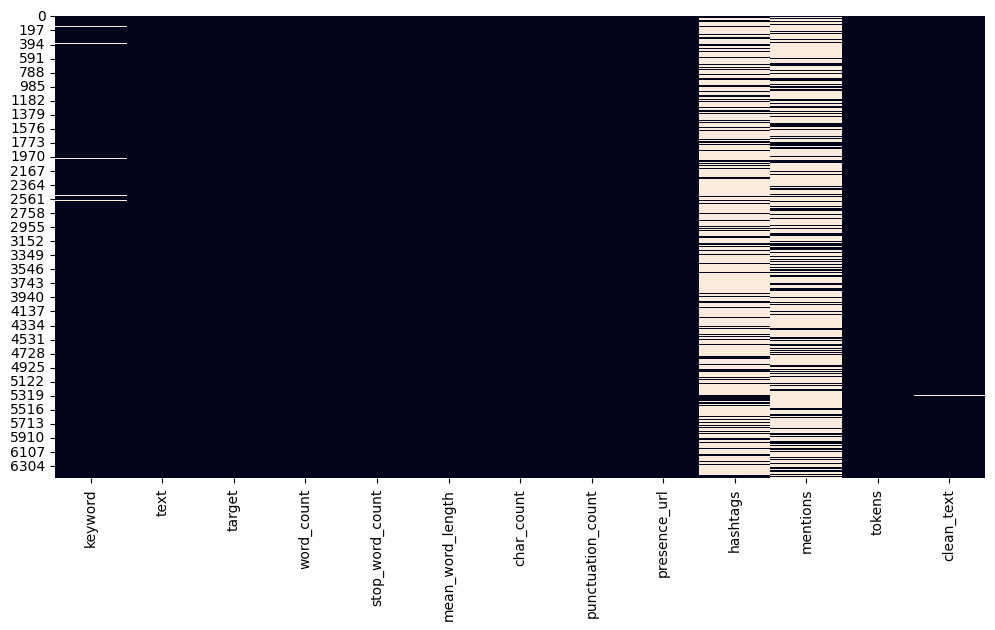

In [142]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isna(), cbar=False)

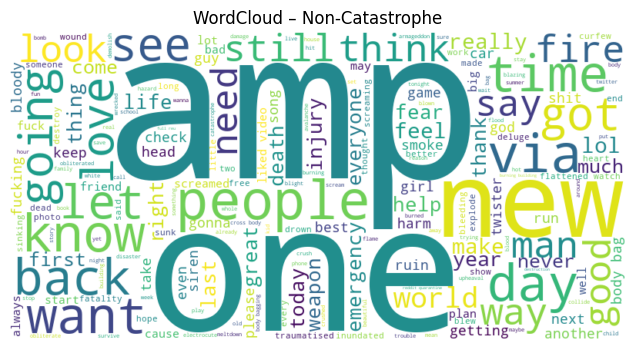

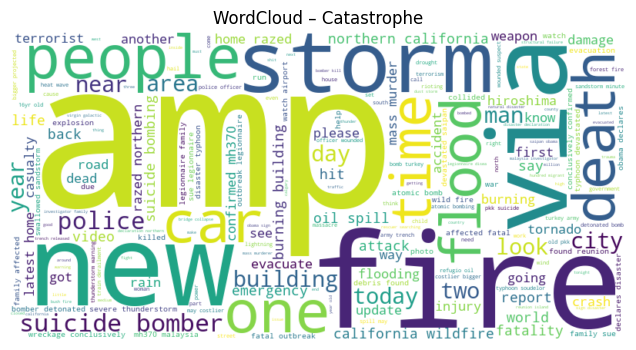

In [143]:


df_negative = df[df["target"] == 0]
df_positive = df[df["target"] == 1]

text_0 = " ".join(df_negative["clean_text"].dropna())
text_1 = " ".join(df_positive["clean_text"].dropna())

wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)


plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()


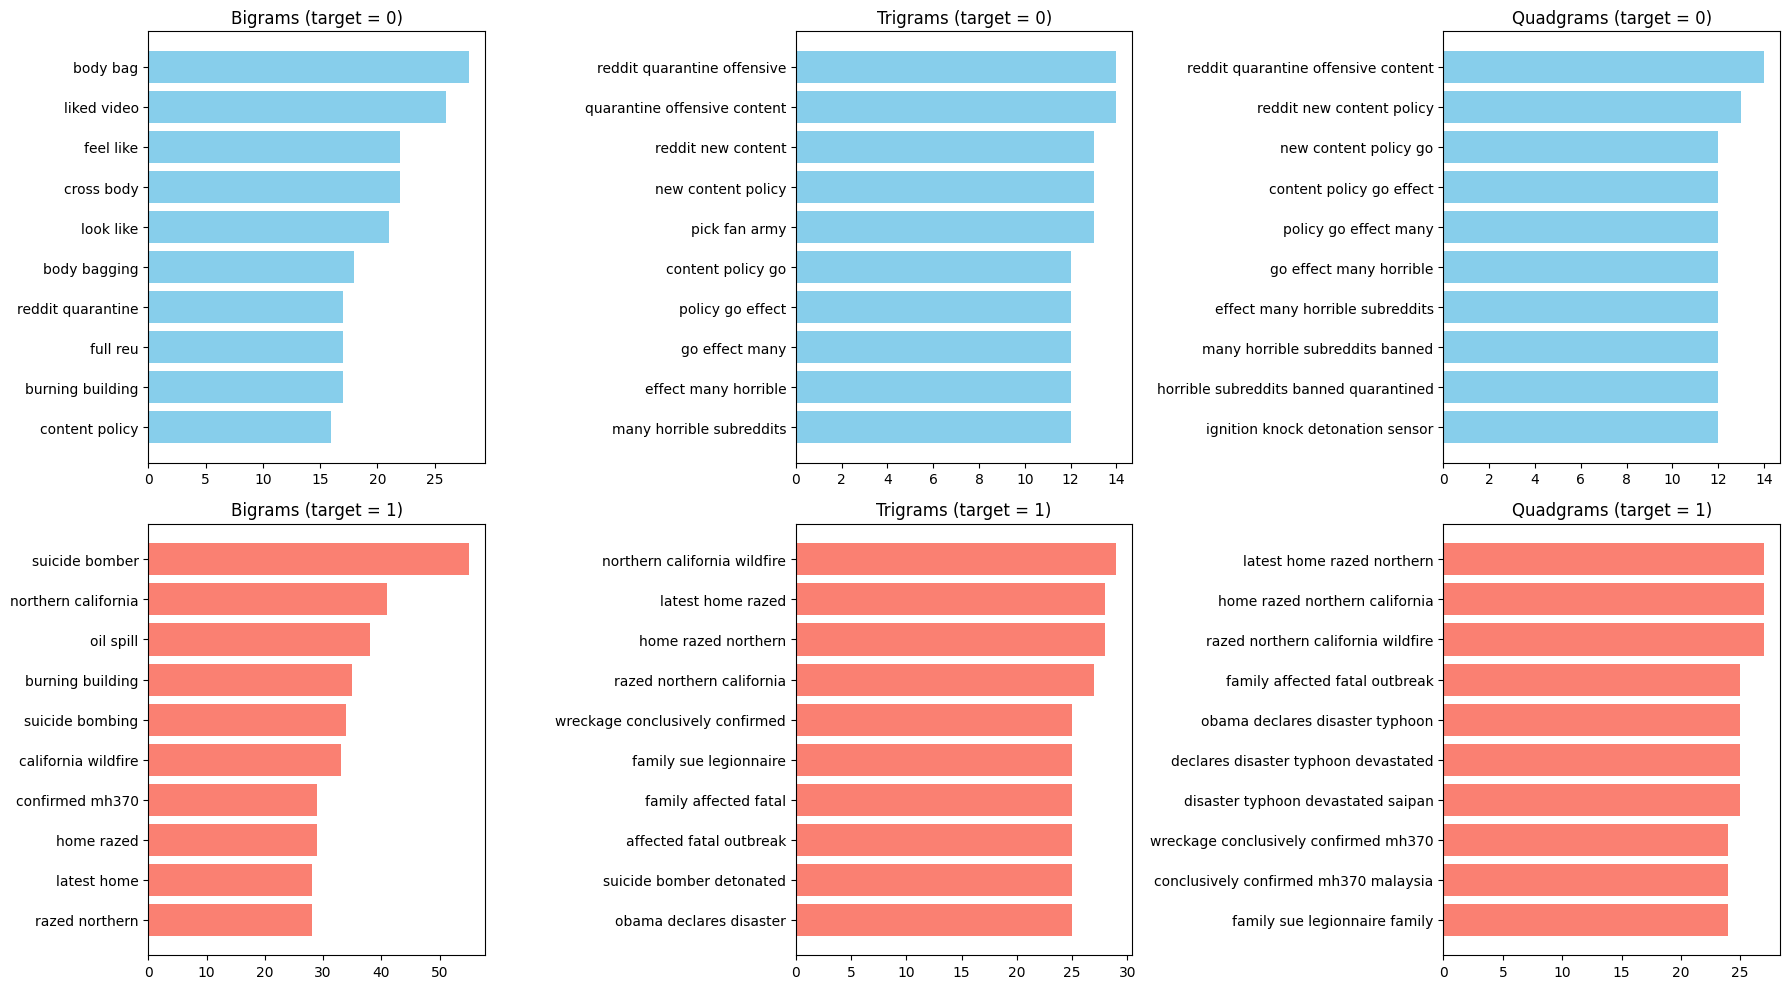

In [144]:
text_0 = df[df["target"] == 0]["clean_text"].dropna().astype(str).tolist()
text_1 = df[df["target"] == 1]["clean_text"].dropna().astype(str).tolist()

# === 3. Fonction de plotting des n-grams ===
def plot_ngrams(corpus, n, color, title):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    sums = X.sum(axis=0)
    freqs = [(word, sums[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    freqs = sorted(freqs, key=lambda x: x[1], reverse=True)[:10]

    words, counts = zip(*freqs)
    plt.barh(words, counts, color=color)
    plt.title(title)
    plt.gca().invert_yaxis()

# === 4. Plot final ===
plt.figure(figsize=(18, 10))

# Classe 0
plt.subplot(2, 3, 1)
plot_ngrams(text_0, 2, 'skyblue', "Bigrams (target = 0)")
plt.subplot(2, 3, 2)
plot_ngrams(text_0, 3, 'skyblue', "Trigrams (target = 0)")
plt.subplot(2, 3, 3)
plot_ngrams(text_0, 4, 'skyblue', "Quadgrams (target = 0)")

# Classe 1
plt.subplot(2, 3, 4)
plot_ngrams(text_1, 2, 'salmon', "Bigrams (target = 1)")
plt.subplot(2, 3, 5)
plot_ngrams(text_1, 3, 'salmon', "Trigrams (target = 1)")
plt.subplot(2, 3, 6)
plot_ngrams(text_1, 4, 'salmon', "Quadgrams (target = 1)")

plt.tight_layout()
plt.show()

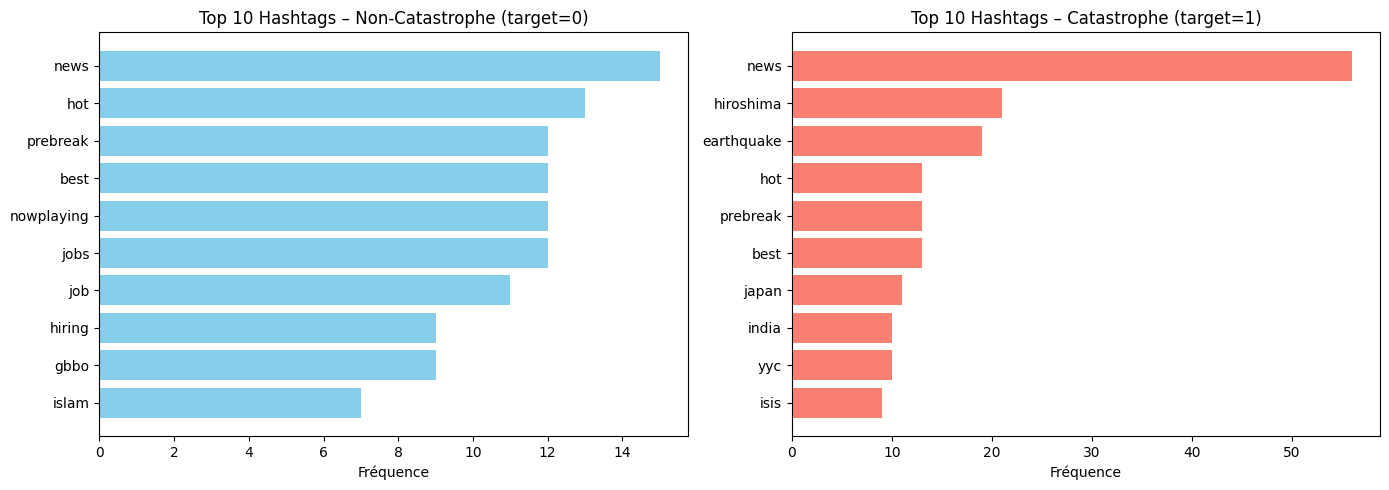

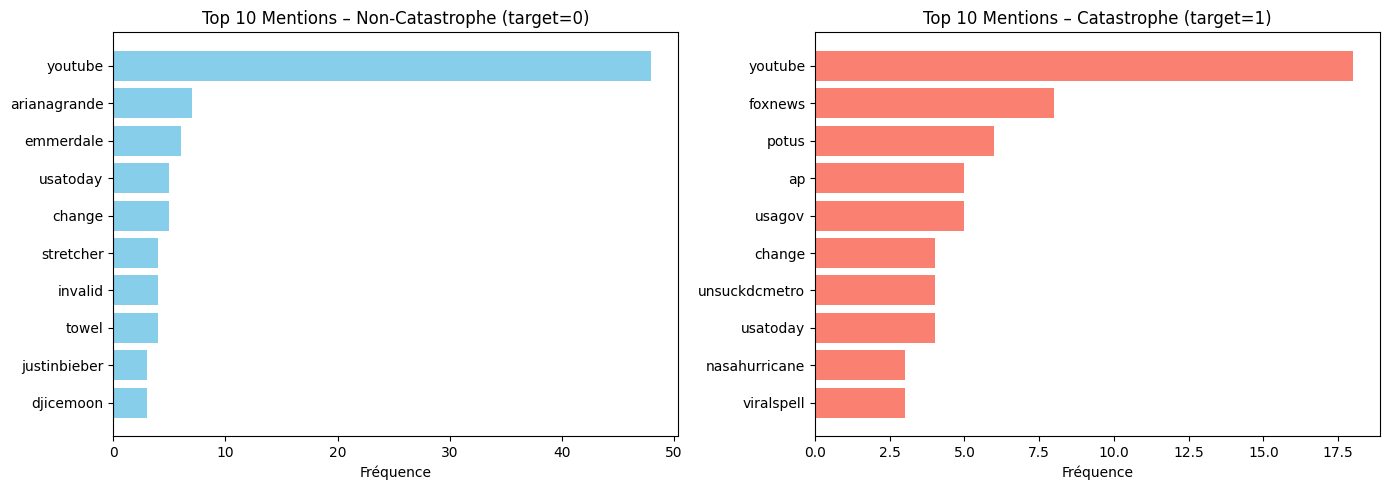

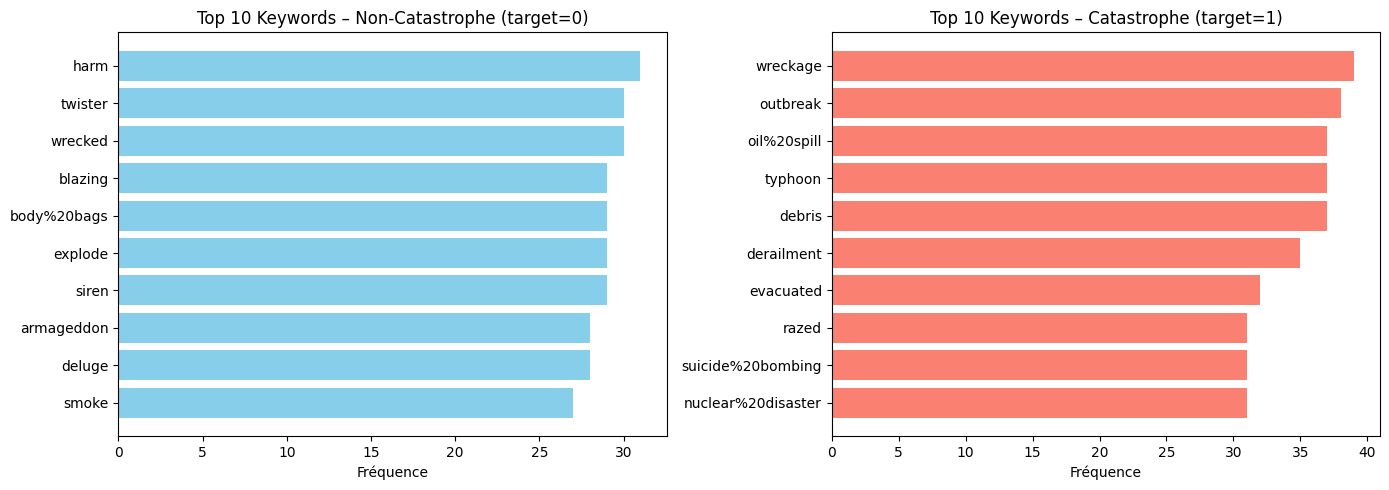

In [145]:
df_positive = df[df["target"] == 1]
df_negative = df[df["target"] == 0]

def plot_top_elements(colonne, label, n=10):
    top_0 = Counter(df_negative[colonne].dropna().str.lower().str.split(", ").sum()).most_common(n)
    top_1 = Counter(df_positive[colonne].dropna().str.lower().str.split(", ").sum()).most_common(n)

    # Subplot
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    for idx, (data, target, color) in enumerate(zip([top_0, top_1], [0, 1], ['skyblue', 'salmon'])):
        labels, counts = zip(*data)
        axs[idx].barh(labels, counts, color=color)
        axs[idx].set_title(f"Top {n} {label}s – {'Catastrophe' if target==1 else 'Non-Catastrophe'} (target={target})")
        axs[idx].invert_yaxis()
        axs[idx].set_xlabel("Fréquence")

    plt.tight_layout()
    plt.show()

# === Appels
plot_top_elements("hashtags", "Hashtag")
plot_top_elements("mentions", "Mention")
plot_top_elements("keyword", "Keyword")

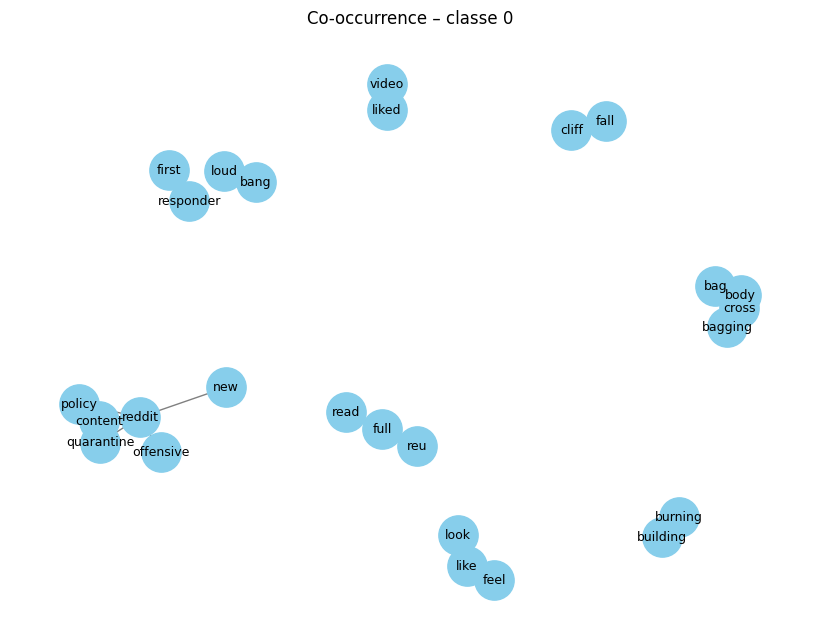

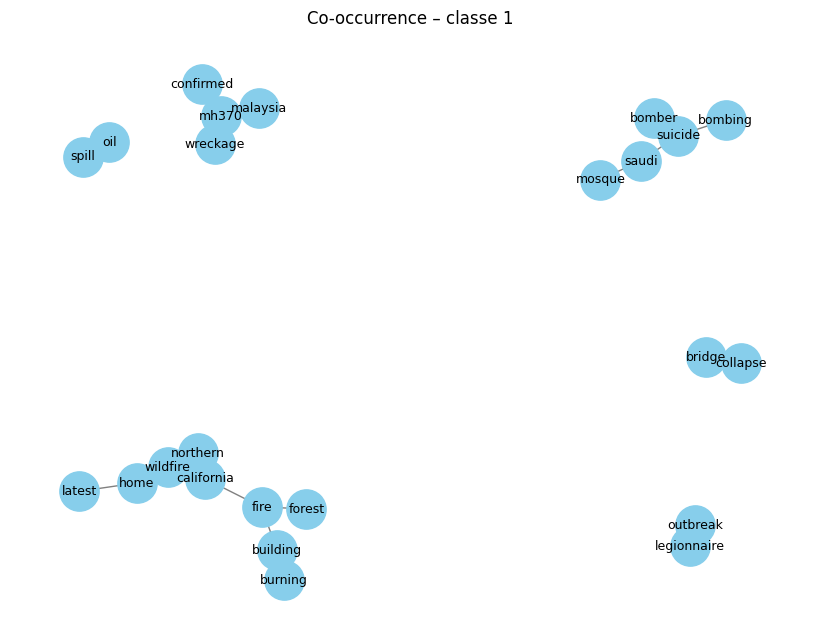

In [146]:
import ast
df["tokens"] = df["tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

def cooc_graph(df_subset, max_edges=20, title="Co-occurrence"):
    cooc = Counter()
    for tokens in df_subset["tokens"].dropna():
        tokens = eval(tokens) if isinstance(tokens, str) else tokens  # au cas où encore en string
        unique_tokens = set(tokens)
        for a, b in itertools.combinations(sorted(unique_tokens), 2):
            cooc[(a, b)] += 1

    # Top co-occurrences
    cooc_df = pd.DataFrame(cooc.items(), columns=["pair", "count"])
    cooc_df = cooc_df.sort_values(by="count", ascending=False).head(max_edges)

    # Création du graphe
    G = nx.Graph()
    for (a, b), count in cooc_df.values:
        G.add_edge(a, b, weight=count)

    # Dessin du graphe
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, k=0.7, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=800, node_color="skyblue", edge_color="gray", font_size=9)
    plt.title(title)
    plt.axis('off')
    plt.show()

# --- Générer les visualisations pour chaque classe ---
df_positive = df[df["target"] == 1]
df_negative = df[df["target"] == 0]

cooc_graph(df_negative, title="Co-occurrence – classe 0")
cooc_graph(df_positive, title="Co-occurrence – classe 1")

In [162]:
import itertools
import networkx as nx
cooc_words_class1 = {
    'wreckage', 'airplane', 'accident', 'suicide', 'bomber', 'murder',
    'airport', 'oil', 'spill', 'building', 'fire', 'burning',
    'forest', 'wildfire', 'bridge', 'collapse', 'outbreak', 'legionnaire'
}

df["nb_words_in_cooc_class1"] = df["tokens"].apply(lambda tokens: sum(w in cooc_words_class1 for w in tokens))


In [163]:
# Définir les ensembles de référence
has_top10_hashtags = {'earthquake', 'wildfire', 'hiroshima', 'genocide'}
nb_top10_mentions = {'usatoday', 'ap', 'nasahurricane', 'foxnews', 'newyorker', 'sharethis', 'yahonews', 'cityofcalgary'}
has_top10_keywords = {'outbreak', 'wreckage', 'oil spill', 'collision', 'derailment', 'fire', 'evacuated', 'earthquake', 'airplane accident', 'sandstorm'}
top_bigrams = {'suicide bomber', 'burning building', 'oil spill', 'mass murder', 'severe thunderstorm'}

# Hashtags
df["has_top10_hashtag"] = clean_and_split(df["hashtags"]).apply(lambda lst: int(any(tag in has_top10_hashtags for tag in lst)))

# Mentions
df["nb_top10_mentions"] = clean_and_split(df["mentions"]).apply(lambda lst: sum(tag in nb_top10_mentions for tag in lst))

# Keywords
df["has_top10_keyword"] = df["keyword"].fillna('').str.lower().apply(lambda k: int(k in has_top10_keywords))

# Bigrams → transformation de tokens en bigrams
from nltk.util import ngrams

def contains_top_bigram(tokens):
    tokens = [t.lower() for t in tokens if isinstance(t, str)]
    bigrams = [' '.join(bg) for bg in ngrams(tokens, 2)]
    return int(any(bigram in top_bigrams for bigram in bigrams))

df["has_top_bigram"] = df["tokens"].apply(contains_top_bigram)


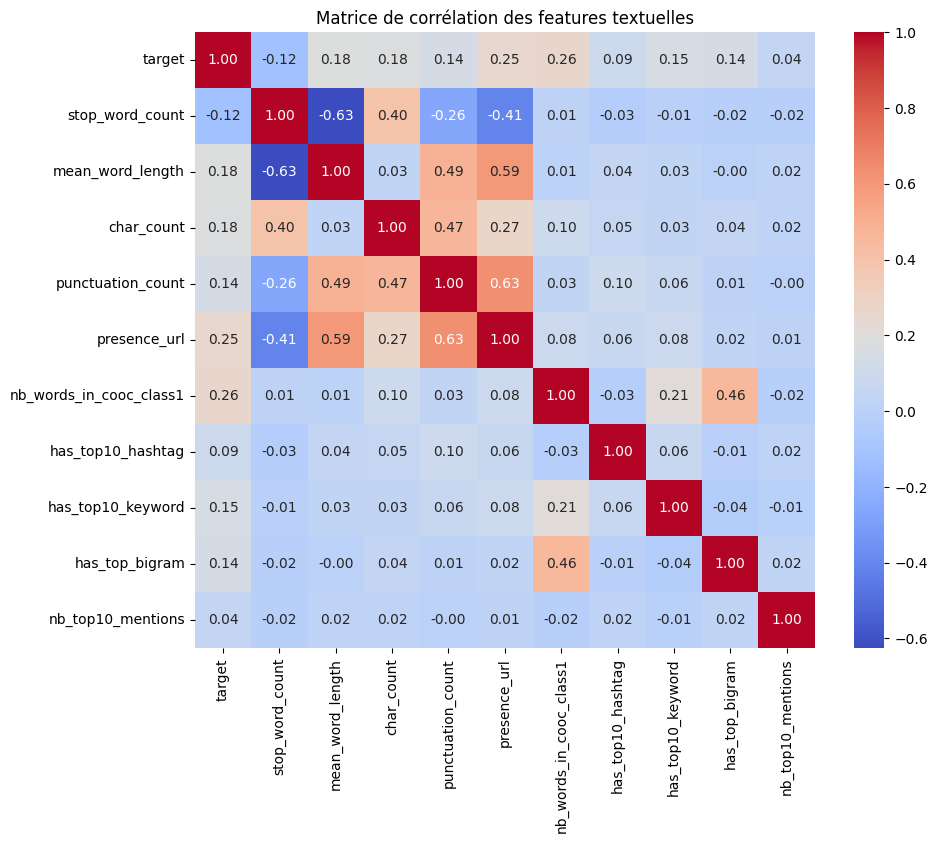

In [164]:
num_cols = df.select_dtypes(include='number').columns

corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation des features textuelles")
plt.show()

In [159]:
df.drop(columns=["word_count", "nb_top10_mentions"], inplace=True)

KeyError: "['word_count', 'nb_top10_mentions'] not found in axis"

In [161]:
df.head()

,keyword,text,target,stop_word_count,mean_word_length,char_count,punctuation_count,presence_url,hashtags,mentions,tokens,clean_text,nb_words_in_cooc_class1,has_top10_hashtag,has_top10_keyword,has_top_bigram
0,crash,motogp indianapolis espargaro layout worrie...,0,2,8.909091,108,15,1,NaN,NaN,"[motogp, indianapolis, espargaro, layout, worr...",motogp indianapolis espargaro layout worry little,0,0,0,0
1,disaster,rt the devereaux disaster exciting scifi,0,1,9.000000,109,15,1,"thriller, scifi, kindle",amznfavorites,"[devereaux, disaster, exciting, scifi]",devereaux disaster exciting scifi,0,0,0,0
2,war%20zone,this bed looks like a war zone,0,3,3.571429,31,1,0,NaN,NaN,"[bed, look, like, war, zone]",bed look like war zone,0,0,0,0
3,blew%20up,i hate people who tweet receipts but know it...,0,11,4.360000,134,5,0,NaN,NaN,"[hate, people, tweet, receipt, know, wrong, wo...",hate people tweet receipt know wrong wont take...,0,0,0,0
4,police,police kill hatchet wielding gunman who opened...,1,1,8.266667,138,11,1,NaN,NaN,"[police, kill, hatchet, wielding, gunman, open...",police kill hatchet wielding gunman opened fir...,1,0,0,0


In [158]:
df.to_csv("../data/go_ml.csv", index=False)